# Topic: COVID-19 Alert HK

#### **1. Analysis of the problem** 
In 2020, COVID-19 has had a strong impact on the world, and Hong Kong has also been hit hard. As the outbreaks of the pandemic repeated frequently and irregularly, in order to effectively control the pandemic situation, the information about the updated cases in the communities is very important for the citizens living in this port city to stay cautious and prevent themselves from getting infected. <br>
However, even though the data collection, recording and analysis have become more and more vital, the degree of difficulty has also become higher. It’s a very challenging task for the news reporters to manage and analyze the pandemic data while they need to cover the latest information to the audience in a short period of time.<br>

#### **2. The topic we cover**
By making full use of the statistics published on the data.gov.hk by the HKSAR government which contained the details of probable/confirmed cases of COVID-19 infection in Hong Kong and provided the public with the CSV document of the raw data. We can create an automated content management system to help the news reporters to master the big picture of the data and find more clues from it to tell the deep information to alert the Hong Kong citizens and give them advice to avoid the exposure to the virus.

#### **3. The function of our system** <br>
Our project, COVID-19 Alert HK, mainly includes the following functions: <br>
● Creating the COVID-19_HK Dataset converting it to SQL. <br>
● Generating data reports automatedly which involves several aspects: total number  cases up to date report; daily report; hospitalized/discharged/deceased report; days  with maximum number of cases report. <br>
● Added reported cases by user themselves. <br>
● Visualizing the data.  <br>


In [6]:
import requests
import pandas as pd
import sqlite3
from sqlite3 import Error
from pathlib import Path
import datetime  
from datetime import timedelta
import pytz  # for timezone()
import matplotlib.pyplot as plt
import textwrap
from IPython.display import display, Markdown, Latex


### SQLite tutorial
### https://www.sqlitetutorial.net/sqlite-python/


### Download the CSV file and store it in disk
r = requests.get('http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv', allow_redirects=True)
# r.status_code

open('enhanced_sur_covid_19_eng.csv', 'wb').write(r.content)


### Create an empty file where the csv data will be dumped
Path('COVID_HK.db').touch()


### Create a database connection and cursor to execute queries
conn = sqlite3.connect('COVID_HK.db')
c = conn.cursor()


### Delete table if it already exists
c.execute('''DROP TABLE IF EXISTS covid_hk''')


### Create an empty table with its own schema
### https://www.sqlite.org/datatype3.html
### 'Date of onset' TEXT, -> is not DATE, as sometimes the entries include "Asymptomatic"
c.execute('''CREATE TABLE covid_hk (
    Case_no INTEGER PRIMARY KEY,
    Report_date DATE NOT NULL,
    Date_of_onset TEXT NOT NULL,
    Gender CHAR(1) NOT NULL,
    Age INTEGER NOT NULL,
    Name_of_hospital_admitted NULL,
    Hospitalised_Discharged_Deceased TEXT NOT NULL,
    HK_Non_HK_resident TEXT NOT NULL,
    Case_classification TEXT NOT NULL,
    Confirmed_probable TEXT NOT NULL
)''')


### Load the csv data into a Pandas DataFrame
data = pd.read_csv('enhanced_sur_covid_19_eng.csv')


### Convert 'Report date' to datetime format, and then use only the date without the time
data['Report date'] = pd.to_datetime(data['Report date'])
data['Report date'] = data['Report date'].dt.date


### Convert spaces in attibutes to underscore, and modify other charachters that might create conflicts with SQL
data.columns = data.columns.str.replace(' ','_')
data.columns = data.columns.str.replace('*','')
data.columns = data.columns.str.replace('.','')
data.columns = data.columns.str.replace('/','_')
data.columns = data.columns.str.replace('-','_')


### Append the csv data into the newly created sqlite table
data.to_sql('covid_hk', conn, if_exists='append', index = False)
# testing
# c.execute('''SELECT * FROM covid_hk''').fetchall()


### Use now() to get current date, yesterday date, and before yesterday date, and store this values in variables
today_date = datetime.datetime.now(pytz.timezone('Asia/Hong_Kong')).date()
# print(today_date)

yesterday_date = today_date - timedelta(days=1)
# print(yesterday_date)

before_yesterday_date = today_date - timedelta(days=2)
# print(before_yesterday_date)


### This function obtains a new consecutive id number
def new_id_number(conn):
    """
    This function obtains a new consecutive id number
    """
    with conn:
        sql = "SELECT MAX(Case_no) FROM covid_hk"
        cur = conn.cursor()
        cur.execute(sql)
        cur.lastrowid
        result = str(cur.lastrowid + 1)
        return result


new_id_number = new_id_number(conn)
# print(new_id_number)

### close this connexion before next programm
conn.close()


print('\n\nCOVID-19_HK Dataset has been created and converted to SQL successfully!\n\n')



COVID-19_HK Dataset has been created and converted to SQL successfully!




In [7]:
def create_connection(db_file):
    """ create a database connection to the SQLite database specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn




def wrap(text):
    # Applying some prettyfication
    wrapper = textwrap.TextWrapper(width=75) 
    word_list = wrapper.wrap(text)
    for element in word_list: 
        print(element)
    sep = ('-' * 75)
    return sep
        
        

def show_options():
    """ Show the options """
    choices = ["Total number cases up to date report", "Daily report", "Hospitalized/Discharged/Deceased report",
            "Days with maximum number of cases report", "Add a reported case", "exit"]
    print("\n\n")
    print('-' * 75)
    print(wrap('''Based on figures provided by the HKSAR Health Department,
the following updates on the COVID-19 statistics are reported:'''))
    print("Please choose one of the following options:")
    print("1. ", choices[0])
    print("2. ", choices[1])
    print("3. ", choices[2])
    print("4. ", choices[3])
    print("5. ", choices[4])
    print("6. ", choices[5])

    
    
def total_number_cases(conn):
    """
    List of total number of reported cases up to date in the database.
    """
    # print("The total number of reported cases up to date is:")
    with conn:
        sql = "SELECT Case_no FROM covid_hk"
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()
        len_result_set = len(result_set)
        print(wrap(f'''TOTAL NUMBER OF CASES REPORT -> There is a total number of {len_result_set}
reported cases up to date.\n'''))

        
        
def yesterday_infection_cases_number(conn, yesterday_date):
    """
    List of total number of reported cases in the database from yesterday.
    """
    # print("The total number of reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Case_no FROM covid_hk WHERE Report_Date='{}'".format(yesterday_date))
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number
        

        
def yesterday_asymptomatic_cases_number(conn, yesterday_date):        
    """
    List of total number of asymptomatic reported cases in the database from yesterday.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Case_no FROM covid_hk WHERE Date_of_onset='Asymptomatic' \
               AND Report_Date='{}'".format(yesterday_date))
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number        
        
        

def before_yesterday_infection_cases_number(conn, before_yesterday_date):
    """
    List of total number of reported cases in the database from before yesterday.
    """
    # print("The total number of reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Case_no FROM covid_hk WHERE Report_Date='{}'".format(before_yesterday_date))
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number
        
        
def before_yesterday_asymptomatic_cases_number(conn, before_yesterday_date):
    """
    List of total number of asymptomatic reported cases in the database from before yesterday.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Case_no FROM covid_hk WHERE Date_of_onset='Asymptomatic' \
               AND Report_Date='{}'".format(before_yesterday_date))
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number
    
    

def daily_report():
    yesterday = yesterday_infection_cases_number(conn, yesterday_date)
    before_yesterday = before_yesterday_infection_cases_number(conn, before_yesterday_date)
    
    if int(yesterday) > int(before_yesterday):
        print(wrap(f'''DAILY REPORT -> The total number of infections recorded yesterday, on {yesterday_date},
is {yesterday_infection_cases_number(conn, yesterday_date)} cases, of which a total of
{yesterday_asymptomatic_cases_number(conn, yesterday_date)} cases are asymptomatic.
The figures show an INCREASE of confirmed cases, compared with {before_yesterday_date},
which had a total of {before_yesterday_infection_cases_number(conn, before_yesterday_date)}
cases, of which a total of {before_yesterday_asymptomatic_cases_number(conn, before_yesterday_date)} 
cases were asymptomatic.'''))
    else:
        print(wrap(f'''DAILY REPORT -> The total number of infections recorded yesterday, on {yesterday_date},
is {yesterday_infection_cases_number(conn, yesterday_date)} cases, of which a total of
{yesterday_asymptomatic_cases_number(conn, yesterday_date)} cases are asymptomatic.
The figures show an DECREASE of confirmed cases, compared with {before_yesterday_date},
which had a total of {before_yesterday_infection_cases_number(conn, before_yesterday_date)}
cases, of which a total of {before_yesterday_asymptomatic_cases_number(conn, before_yesterday_date)}
cases were asymptomatic.'''))
    

  
    
    
def hospitalized_number(conn):
    """
    List of total number of reported hospitalized cases up to date in the database.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Hospitalised_Discharged_Deceased FROM covid_hk \
               WHERE Hospitalised_Discharged_Deceased='Hospitalised'")
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number
       
def discharged_number(conn):
    """
    List of total number of reported discharged cases up to date in the database.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Hospitalised_Discharged_Deceased FROM covid_hk \
               WHERE Hospitalised_Discharged_Deceased='Discharged'")
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number
    

def deseased_number(conn):
    """
    List of total number of reported deceased cases up to date in the database.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Hospitalised_Discharged_Deceased FROM covid_hk \
               WHERE Hospitalised_Discharged_Deceased='Deceased'")
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number


def no_admission_number(conn):
    """
    List of total number of reported no admission cases up to date in the database.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Hospitalised_Discharged_Deceased FROM covid_hk \
               WHERE Hospitalised_Discharged_Deceased='No admission'")
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number

    
def to_be_provided_number(conn):
    """
    List of total number of reported to be provided cases up to date in the database.
    """
    # print("The total number of asymptomatic reported cases from yesterday is:")
    with conn:
        sql = ("SELECT Hospitalised_Discharged_Deceased FROM covid_hk \
               WHERE Hospitalised_Discharged_Deceased='To be provided'")
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()        
        number = len(result_set)
        return number    
    
    
    
def hospitalised_discharged_deceased_report():
               print(wrap(f'''TOTAL NUMBER OF HOSPITALIZED, DISCHARGED, AND DECEASED PATIENTS REPORT -> 
The total number of hospitalized patients currently is {hospitalized_number(conn)},
the total number of discharged patients up to date is {discharged_number(conn)},
and the total number of deseased patients up to date is {deseased_number(conn)}.
Furthermore, the total number of not admitted pattients is {no_admission_number(conn)},
and the total number of patients in status "to be provided" is {to_be_provided_number(conn)}.'''))
               
             
   
    
def days_max_cases(conn):
    """
    Reports the two days with maximum number of reported cases
    """
    with conn:
        sql = """SELECT Report_date, count(*) as result FROM covid_hk 
        GROUP BY Report_date ORDER BY Result DESC LIMIT 2"""
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()
        max_date1 = result_set[0][0]
        max_number1 = result_set[0][1]
        max_date2 = result_set[1][0]
        max_number2 = result_set[1][1]
        #print(result_set)
        print(wrap(f'''DAYS WITH MAXIMUM NUMBER OF CASES REPORT -> The day with the maximum
number of recorded cases was {max_date1},
with a total number of {max_number1} reported cases; and the day with second maximum
number of cases recorded was {max_date2}, with a total number of {max_number2}
reported cases.'''))
    
    
  
   

def add_reported_case(conn, new_id_number):
    """
    Insert data into database
    A sample input is: 
    
    [6000, 16/11/2020, Asymptomatic, M, 1, To be provided, HK resident, Imported case, Confirmed]

    """
    line = input(wrap(f"""ADD A NEW REPORTED CASE -> Please input: Case no, Report_date, Date_of_onset, Gender, Age, \
Hospitalised_Discharged_Deceased, HK_Non_HK_resident, Case_classification, Confirmed_probable: 
For example: (6000, 2020-12-09, Asymptomatic, M, 50, To be provided, HK resident, Imported case, Confirmed)
Please PROVIDE A 'Case no' NUMBER EQUAL OR GREATER THAN {new_id_number}."""))
    values = line.split(',')
    print('\n')
    print(wrap(f"""The following values have been added: {values}"""))
    
    for i in range(0, len(values)):
        values[i] = values[i].strip()
    with conn:
        sql = "INSERT INTO covid_hk VALUES(?, ?, ?, ?, ?, NULL, ?, ?, ?, ?)"
        cur = conn.cursor()
        cur.execute(sql, (values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7], values[8]))
        return cur.lastrowid
        
    
    
    
    
"""main"""
database = "COVID_HK.db"
conn = create_connection(database)
while True:
    show_options()
    choice = input('Please enter your option: ')
    print('\n')
    # with conn:
    if choice == '6':
        conn.close() # close the connection
        break
    elif choice == '1':
        total_number_cases(conn)
    elif choice == '2':
        daily_report()
    elif choice == '3':
        hospitalised_discharged_deceased_report()
    elif choice == '4':
        days_max_cases(conn)
    elif choice == '5':    
        add_reported_case(conn, new_id_number)
    else:
        print("This option is not available")
        continue




---------------------------------------------------------------------------
Based on figures provided by the HKSAR Health Department, the following
updates on the COVID-19 statistics are reported:
---------------------------------------------------------------------------
Please choose one of the following options:
1.  Total number cases up to date report
2.  Daily report
3.  Hospitalized/Discharged/Deceased report
4.  Days with maximum number of cases report
5.  Add a reported case
6.  exit
Please enter your option: 1


TOTAL NUMBER OF CASES REPORT -> There is a total number of 7076 reported
cases up to date.
---------------------------------------------------------------------------



---------------------------------------------------------------------------
Based on figures provided by the HKSAR Health Department, the following
updates on the COVID-19 statistics are reported:
---------------------------------------------------------------------------
Please choose one of the fo

<h1><center>Visualization Programms (1)</center></h1>

<text> The following 3 visualization programms have been developed as individual programms because when the statement "continue" was executed, the Main programm did not show the graph, instead, it just jumped to show the options. Only when the option 'close main programm' was selected, the graph was shown. So, the next 3 programms are in indivudual cells to work around this issue.</text>




---------------------------------------------------------------------------
Based on figures provided by the HKSAR Health Department, the following
updates on the COVID-19 statistics are reported:
---------------------------------------------------------------------------
Please choose one of the following options:
1.  Generate 'Daily statistics' report graph
2.  exit
Please enter your option: 1


(Please wait, the graph might take a moment to be generated)


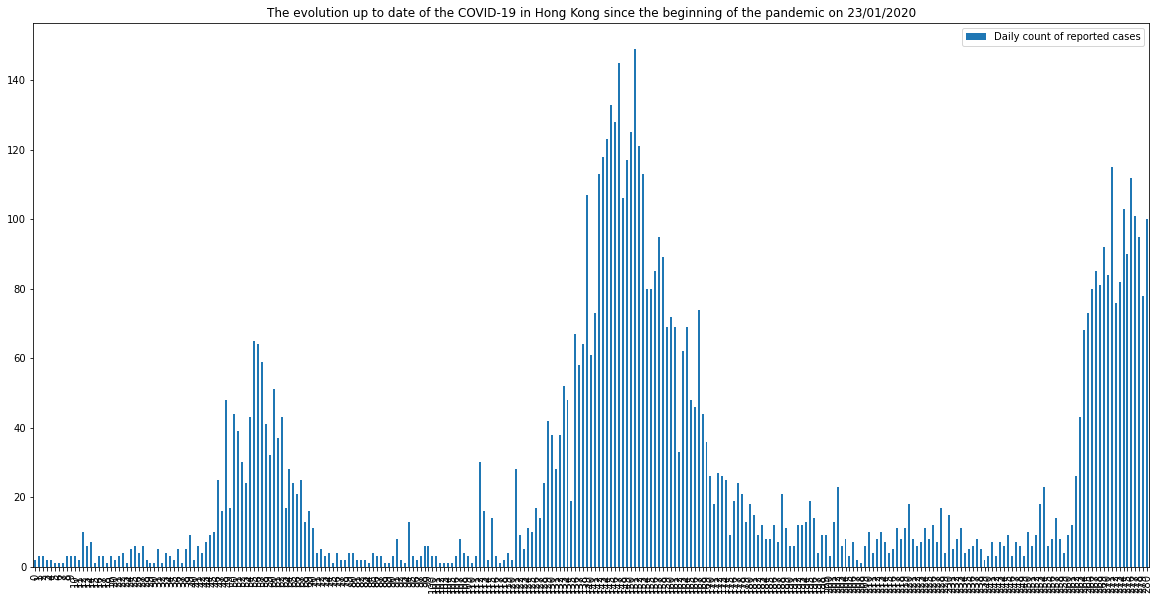

In [8]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn



def show_options():
    """ Show the options """
    choices = ["Generate 'Daily statistics' report graph", "exit"]
    print("\n\n")
    print('-' * 75)
    print(wrap('''Based on figures provided by the HKSAR Health Department,
the following updates on the COVID-19 statistics are reported:'''))
    print("Please choose one of the following options:")
    print("1. ", choices[0])
    print("2. ", choices[1])
    
    

def daily_report_graph(conn):
    '''
    The evolution up to date of the COVID-19 in Hong Kong since the beginning of the pandemic on 23/01/2020
    '''
    with conn:
        sql = '''SELECT Case_no, Report_date, count(*) as total_cases_per_day 
        FROM covid_hk GROUP BY Report_date ORDER BY Case_no'''
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()
        #print(result_set)
        
        df_grouped = pd.DataFrame(result_set, columns=['Case_no', 'Report_date', 'Daily count of reported cases'])
        # df_grouped.head()  
        
        del df_grouped['Case_no']
        
        print('(Please wait, the graph might take a moment to be generated)')
        # print('The evolution up to date of the COVID-19 in Hong Kong since the beginning of the pandemic on 23/01/2020 is represented in the following graph:'
        
        plot = df_grouped.plot(kind='bar', figsize=(20,10), title='The evolution up to date of the COVID-19 in Hong Kong since the beginning of the pandemic on 23/01/2020')
        plot_saved_to_disk = plt.savefig('covid_hk_daily_evolution_graph_' + str(today_date) + '.png')
        return plot, plot_saved_to_disk


    
"""main"""
database = "COVID_HK.db"
conn = create_connection(database)
while True:
    show_options()
    choice = input('Please enter your option: ')
    print('\n')
    # with conn:
    if choice == '2':
        conn.close() # close the connection
        break
    elif choice == '1':
        daily_report_graph(conn)
        break
    else:
        print("This option is not available")
        continue
        
        
        


<h1><center>Visualization Programms (2)</center></h1>




---------------------------------------------------------------------------
Based on figures provided by the HKSAR Health Department, the following
updates on the COVID-19 statistics are reported:
---------------------------------------------------------------------------
Please choose one of the following options:
1.  Generate 'Gender' report graph
2.  exit
Please enter your option: 1


(Please wait, the graph might take a moment to be generated)


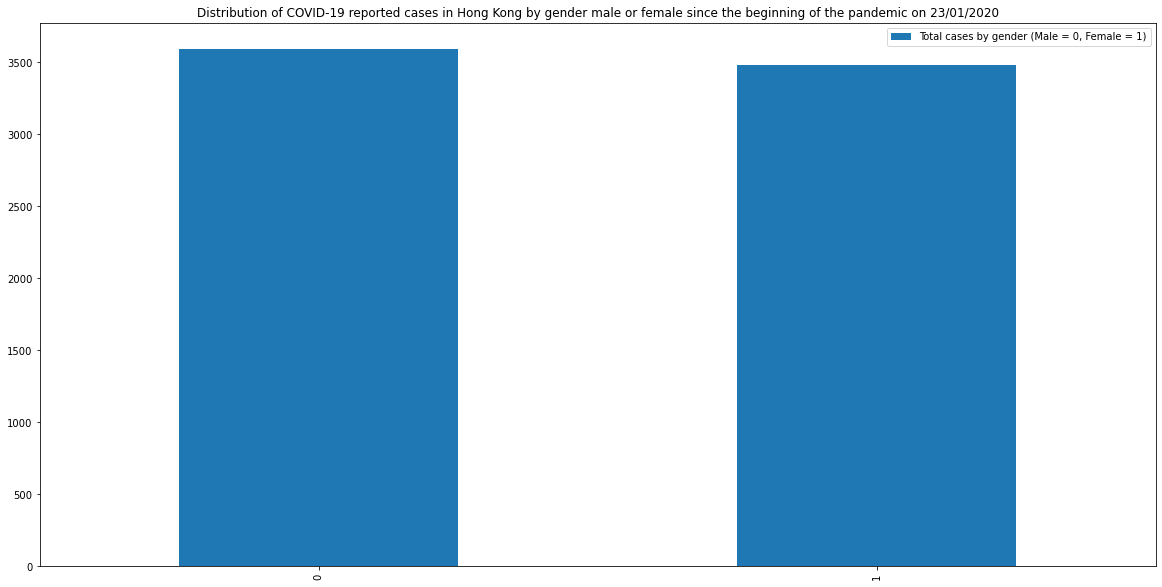

In [9]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn


def show_options():
    """ Show the options """
    choices = ["Generate 'Gender' report graph", "exit"]
    print("\n\n")
    print('-' * 75)
    print(wrap('''Based on figures provided by the HKSAR Health Department,
the following updates on the COVID-19 statistics are reported:'''))
    print("Please choose one of the following options:")
    print("1. ", choices[0])
    print("2. ", choices[1])
    
    

def gender_graph(conn):
    '''
    Distribution of COVID-19 reported cases in Hong Kong by gender male or female since the beginning of the pandemic on 23/01/2020
    '''
    with conn:
        sql = 'SELECT Gender, count(*) as total_cases FROM covid_hk GROUP BY Gender'
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()
        # print(result_set)
        
        df_grouped = pd.DataFrame(result_set, columns=['Gender', 'Total cases by gender (Male = 0, Female = 1)'])
        # df_grouped.head()  
        
        print('(Please wait, the graph might take a moment to be generated)')
        # print('The evolution up to date of the COVID-19 in Hong Kong since the beginning of the pandemic on 23/01/2020 is represented in the following graph:'
        
        plot = df_grouped.plot(kind='bar', figsize=(20,10), title='Distribution of COVID-19 reported cases in Hong Kong by gender male or female since the beginning of the pandemic on 23/01/2020')
        plot_saved_to_disk = plt.savefig('covid_hk_gender_graph_' + str(today_date) + '.png')
        return plot, plot_saved_to_disk


    
"""main"""
database = "COVID_HK.db"
conn = create_connection(database)
while True:
    show_options()
    choice = input('Please enter your option: ')
    print('\n')
    # with conn:
    if choice == '2':
        conn.close() # close the connection
        break
    elif choice == '1':
        gender_graph(conn)
        break
    else:
        print("This option is not available")
        continue

<h1><center>Visualization Programms (3)</center></h1>




---------------------------------------------------------------------------
Based on figures provided by the HKSAR Health Department, the following
updates on the COVID-19 statistics are reported:
---------------------------------------------------------------------------
Please choose one of the following options:
1.  Generate 'Age' report graph
2.  exit
Please enter your option: 1


(Please wait, the graph might take a moment to be generated)


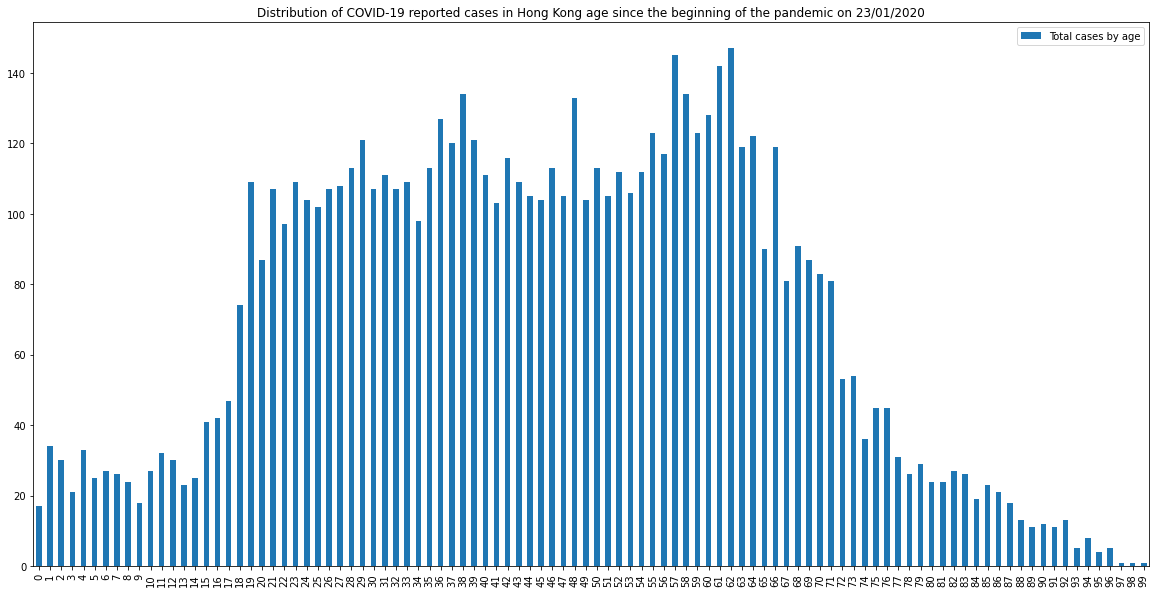

In [10]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return conn



def show_options():
    """ Show the options """
    choices = ["Generate 'Age' report graph", "exit"]
    print("\n\n")
    print('-' * 75)
    print(wrap('''Based on figures provided by the HKSAR Health Department,
the following updates on the COVID-19 statistics are reported:'''))
    print("Please choose one of the following options:")
    print("1. ", choices[0])
    print("2. ", choices[1])


    
    
def age_report_graph(conn):
    '''
    Distribution of COVID-19 reported cases in Hong Kong age since the beginning of the pandemic on 23/01/2020
    '''
    with conn:
        sql = 'SELECT Age, count(*) as total_cases FROM covid_hk GROUP BY Age'
        cur = conn.cursor()
        cur.execute(sql)
        result_set = cur.fetchall()
        # print(result_set)
        
        df_grouped = pd.DataFrame(result_set, columns=['Age', 'Total cases by age'])
        # df_grouped.head()  
        
        del df_grouped['Age']
        
        print('(Please wait, the graph might take a moment to be generated)')
        # print('The evolution up to date of the COVID-19 in Hong Kong since the beginning of the pandemic on 23/01/2020 is represented in the following graph:'
        
        plot = df_grouped.plot(kind='bar', figsize=(20,10), title='Distribution of COVID-19 reported cases in Hong Kong age since the beginning of the pandemic on 23/01/2020')
        plot_saved_to_disk = plt.savefig('covid_hk_age_graph_' + str(today_date) + '.png')
        return plot, plot_saved_to_disk


    
"""main"""
database = "COVID_HK.db"
conn = create_connection(database)
while True:
    show_options()
    choice = input('Please enter your option: ')
    print('\n')
    # with conn:
    if choice == '2':
        conn.close() # close the connection
        break
    elif choice == '1':
        age_report_graph(conn)
        break
    else:
        print("This option is not available")
        continue